In [1]:
import sys, os, distutils.core
sys.path.insert(0, os.path.abspath('../../../detectron2'))
sys.path.insert(0, os.path.abspath('../../../'))
sys.path.insert(0, os.path.abspath('.'))
os.environ['DETECTRON2_DATASETS'] = '/home/liwa/data/datasets/'
from detectron2.data import DatasetCatalog, MetadataCatalog
from oneformer.data.datasets.register_yeast_panoptic_annos_semseg import register_all_yeast_panoptic_annos_sem_seg
from configs.yeast_panoptics.cityscapes_panoptic import register_all_yeastcity_panoptic
from detectron2.config import get_cfg
from detectron2.projects.panoptic_deeplab import (
    PanopticDeeplabDatasetMapper,
    add_panoptic_deeplab_config,
)
import detectron2.data.transforms as T
from detectron2.data import MetadataCatalog, build_detection_train_loader
import numpy as np
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

/home/liwa/miniconda3/envs/oneformer/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cfg = get_cfg()
add_panoptic_deeplab_config(cfg)
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library

cfg.merge_from_file("/home/liwa/data/oneformer_output/output/config.yaml")
# cfg.DATASETS.TRAIN = ("yeastcity_train",)
# cfg.DATASETS.TEST = ("yeastcity_train",)
dataset_dicts = DatasetCatalog.get(cfg.DATASETS.TRAIN[0])
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

In [4]:
cfg.INPUT.CROP.SIZE = [1024,1024]
cfg.SOLVER.IMS_PER_BATCH = 8
def build_sem_seg_train_aug(cfg):
    augs = [
        T.RescaleShortestEdge(
            [0.5, 0.75, 1, 1.25, 1.5, 2],
            4096,
            'choice',
        )
    ]
    augs.append(T.RandomApply(T.RandomFlip(), 0.5))
    augs.append(T.RandomApply(T.RandomBrightness(intensity_min=0.5, intensity_max=1.5), 0.5))
    augs.append(T.RandomApply(T.RandomContrast(intensity_min=0.5, intensity_max=1.5), 0.5))
    if cfg.INPUT.CROP.ENABLED:
        augs.append(T.FixedSizeCrop(cfg.INPUT.CROP.SIZE))
    return augs
# cfg.INPUT.CROP.ENABLED = False

In [5]:
mapper = PanopticDeeplabDatasetMapper(cfg, augmentations=build_sem_seg_train_aug(cfg))
data_loader = build_detection_train_loader(cfg, mapper=mapper)

In [6]:
data_iter = iter(data_loader)

In [7]:
first_batch = next(data_iter)

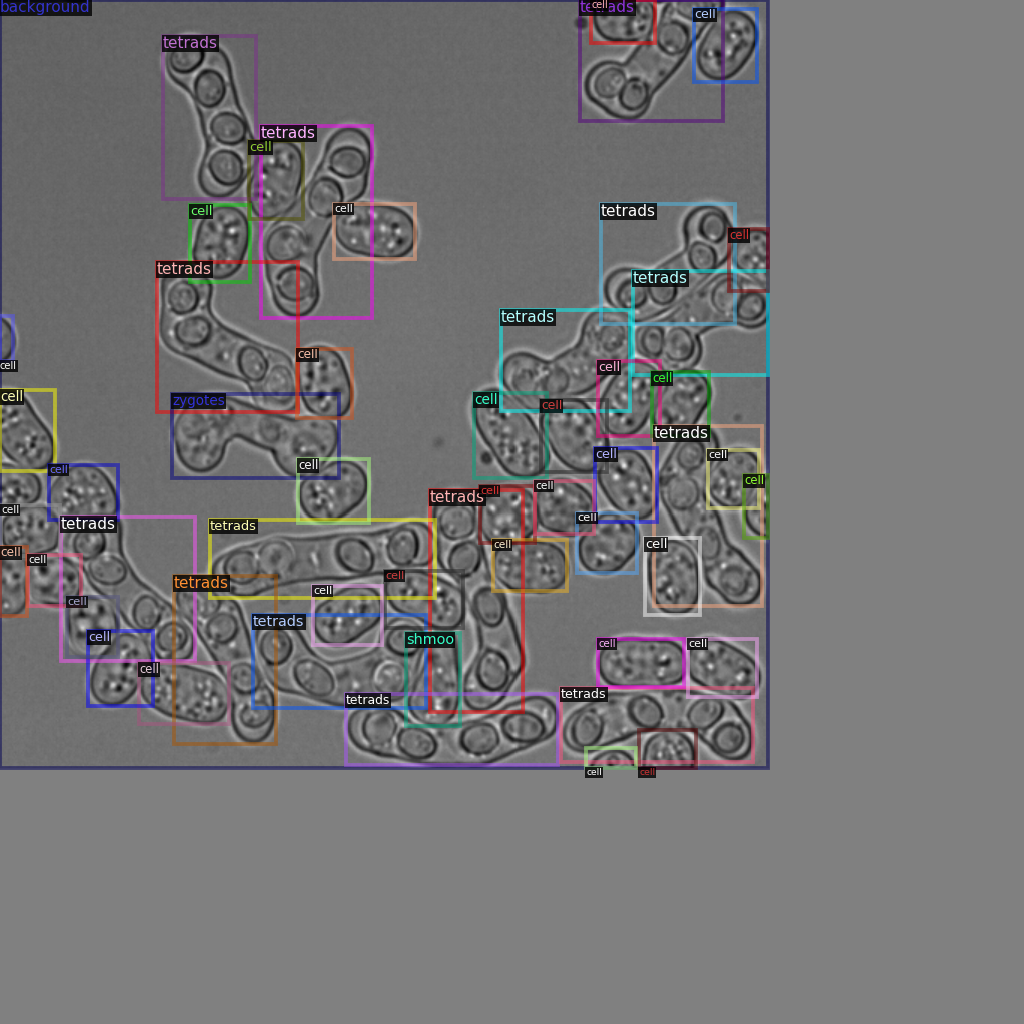

(1024, 1024, 3)


In [15]:
per_image = first_batch[np.random.randint(0, 8)]
img = per_image['image'].numpy().transpose(1, 2, 0)  # Convert to HWC
# img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV
visualizer = Visualizer(img, metadata=metadata, scale=1)  # Add metadata if available
vis = visualizer.draw_dataset_dict({"annotations": per_image["segments_info"]})
cv2_imshow(vis.get_image()[:, :, ::-1])
print(img.shape)

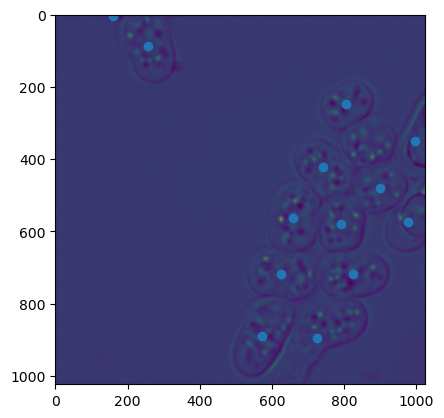

In [9]:
plt.imshow(per_image["sem_seg_weights"])
plt.imshow(per_image["image"][0], alpha=0.5)
points = np.array(per_image["center_points"])
plt.scatter(points[:,1],points[:,0])

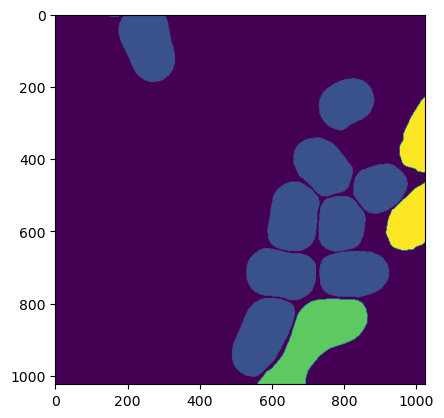

In [10]:
plt.imshow(per_image["sem_seg"])

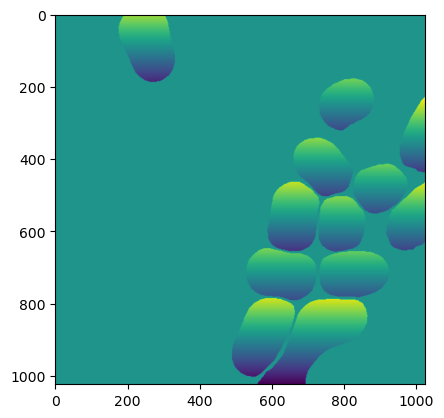

In [11]:
plt.imshow(per_image["offset"][0])

In [281]:
# Create a mapping dictionary
import numpy as np

# Your original 2D numpy array
array_2d = np.array([
    [1001, 2004, 0],
    [4, 5, 6],
    [7, 8, 9],
    [10, 1003, 2001]
])


mapping = {1: 33, 2: 20, 3: 30, 4: 40, 5: 50, 6: 60, 7: 70, 8: 80, 9: 90, 10: 100}

# Use np.vectorize to apply the mapping
map_function = np.vectorize(mapping.get)

# Map the values in the 2D array
new_array_2d = map_function(array_2d)

print(new_array_2d)

[[None None None]
 [40 50 60]
 [70 80 90]
 [100 None None]]


In [282]:
existed_max_id = 56

In [283]:
unique_id = np.unique(array_2d)[1:]
label = unique_id % 1000
sem_label = unique_id // 1000

In [284]:
mapping = {0:0}
for old_id, sem_id in zip(unique_id, sem_label):
    new_id = existed_max_id + sem_id*1000
    mapping[old_id] = new_id
    existed_max_id += 1

map_function = np.vectorize(mapping.get)
new_array_2d = map_function(array_2d)

In [285]:
new_array_2d

array([[1063, 2066,    0],
       [  56,   57,   58],
       [  59,   60,   61],
       [  62, 1064, 2065]])

In [297]:
def reset_value(old_array, existed_max_id=1):
    unique_id = np.unique(old_array)[1:]
    label = unique_id % 1000
    sem_label = unique_id // 1000
    mapping = {0:0}
    for old_id, sem_id in zip(unique_id, sem_label):
        new_id = existed_max_id + sem_id*1000
        mapping[old_id] = new_id
        existed_max_id += 1
    
    map_function = np.vectorize(mapping.get)
    new_array = map_function(old_array)
    return new_array, existed_max_id

In [314]:
new_array, new_max_id = reset_value(new_array_2d, existed_max_id=new_max_id)

In [315]:
new_max_id

105

In [316]:
new_array

array([[1101, 2104,    0],
       [  94,   95,   96],
       [  97,   98,   99],
       [ 100, 1102, 2103]])